<a href="https://colab.research.google.com/github/valy3124/SupervisedLearning/blob/main/MONAI_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Laborator 4 - Clasificarea imaginilor medicale utilizând MONAI

### Setup environment


In [48]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-10-30 10:52:59.831538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 10:52:59.851799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 10:52:59.857750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 10:53:00.938506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Setup imports

In [49]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    Resize
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.5.dev2443
Numpy version: 1.26.4
Pytorch version: 2.5.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d508ba780862a6459326c812e09188838c25bdc5
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.20.0+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

### Setarea directorului de date

Putem specifica un director unde dorim să salvăm datele folosind variabila de mediu MONAI_DATA_DIRECTORY. Acest lucru ne permite să salvăm rezultatele și să reutilizăm fișierele descărcate. Dacă nu este specificată o cale explicită, va fi utilizat un director temporar.

După rularea acestui cod, dacă ne uităm în secțiunea Files din Colab, vom observa că a fost creat un director numit "MONAI". Acesta este directorul în care vom stoca datele și rezultatele generate de MONAI.

In [50]:
# Setăm variabila de mediu MONAI_DATA_DIRECTORY
os.environ["MONAI_DATA_DIRECTORY"] = "MONAI"

# Verificăm că variabila a fost setată corect
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

MONAI


### Descărcarea setului de date

MedNIST este un set de date utilizat în domeniul imagisticii medicale, conceput pentru a facilita dezvoltarea și evaluarea algoritmilor de clasificare a imaginilor medicale. Setul conține peste 100.000 de imagini din șase categorii distincte: radiografii ale toracelui, CT-uri craniene, mamografii, ecografii abdominale, RMN-uri ale genunchiului și imagini ale coloanei vertebrale. MedNIST a fost creat pentru a sprijini cercetarea în învățarea automată și deep learning, oferind un punct de plecare pentru antrenarea și testarea rețelelor neurale în sarcinile de clasificare medicală, contribuind astfel la dezvoltarea soluțiilor automatizate în diagnosticarea medicală.

MedNIST este un set de date pe care îl folosim cu scop didactic datorită dimensiunii reduse a imaginilor, ceea ce îl face ideal pentru sarcinile de învățare automată. Aceste imagini sunt suficient de mici și simplu de procesat, permițându-ne să lucrăm rapid și eficient în cadrul laboratoarelor, fără a fi necesare resurse computaționale mari. Astfel, MedNIST reprezintă un instrument excelent pentru înțelegerea și aplicarea algoritmilor de clasificare a imaginilor medicale.


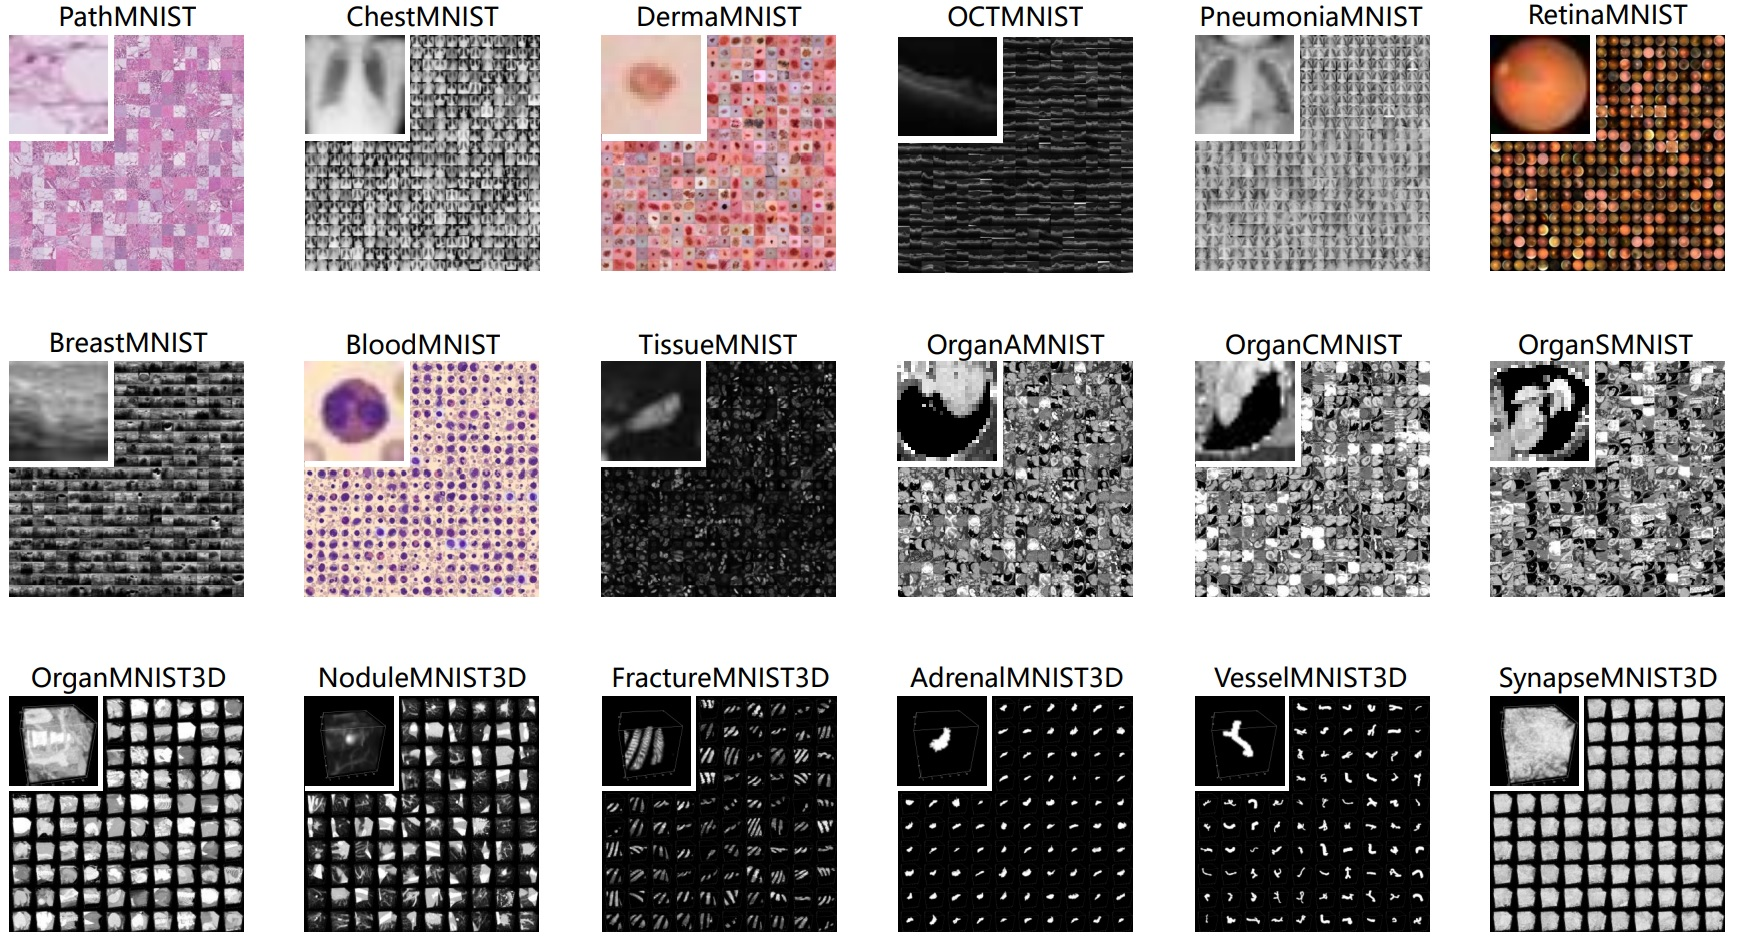

In [51]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

### Varianta deterministică pentru reproductibilitate

Pentru a obține rezultate reproducibile în învățarea automată, setăm niște seed-uri pentru a avea o antrenare în mod determinist. Asta înseamnă că forțăm algoritmul să ruleze același lucru de fiecare dată, chiar și în prezența elementelor care, în mod normal, ar introduce variabilitate (de exemplu, inițializările aleatoare ale ponderilor sau ordinea de citire a datelor). Prin configurarea unei metode de antrenare în manieră deterministică, ne asigurăm că, la fiecare rulare a unui model, vom obține aceleași rezultate, ceea ce este esențial pentru evaluarea corectă și replicarea experimentelor. În practică, acest lucru implică setarea unui seed aleator fix pentru funcțiile care utilizează elemente aleatorii și dezactivarea operațiunilor care ar putea produce rezultate nedeterministe.

În MONAI, acest aspect este gestionat prin funcția set_determinism, care ne permite să stabilim un seed fix și să dezactivăm operațiunile nedeterministe.

In [52]:
set_determinism(seed=42)

### Citirea datelor

În prima etapă a procesului de prelucrare a datelor, citim numele fișierelor de imagini din folderele dataset-ului. Este important să verificăm conținutul fișierelor din dataset și să prezentăm câteva statistici relevante. Dataset-ul conține 6 foldere: Hand, AbdomenCT, CXR, ChestCT, BreastMRI și HeadCT. Aceste foldere reprezintă etichetele pe care le vom folosi pentru a antrena modelul nostru de clasificare. Prin analiza acestor foldere, putem obține o înțelegere mai bună a distribuției datelor și a diversității imaginilor, aspecte esențiale pentru optimizarea performanței modelului.

In [53]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")


Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


### Exercițiul 1

Pornind de la informațiile citite anterior, realizați un grafic în care să prezentați distribuția numărului de imagini pentru fiecare clasă.

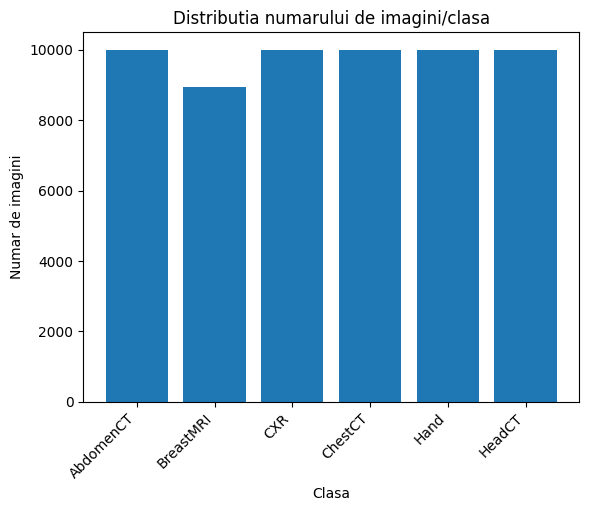

In [54]:
# TODO 1
plt.bar(class_names, num_each)
plt.xlabel("Clasa")
plt.ylabel("Numar de imagini")
plt.title("Distributia numarului de imagini/clasa")
plt.xticks(rotation=45, ha='right')
plt.show()

### Exercițiul 2

Scrieți un cod care să aleagă aleator câte o imagine pentru fiecare clasă de și realizați un grafic cu aceste imagini pentru a verifica vizual datele.

Pentru citirea unei imagini putem folosi:

```img = PIL.Image.open(img_path)```

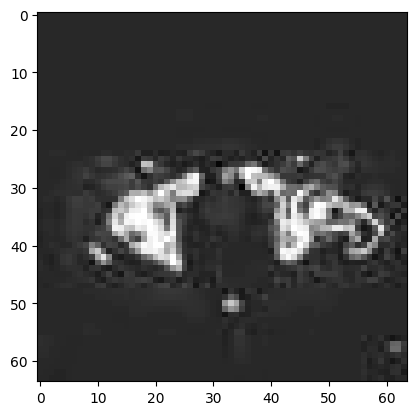

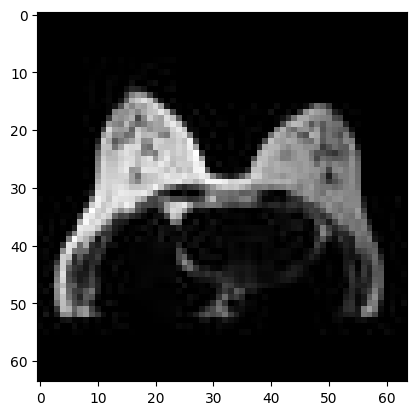

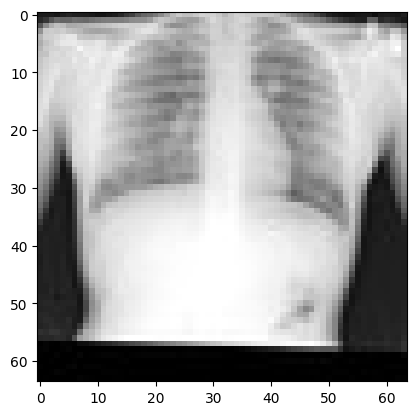

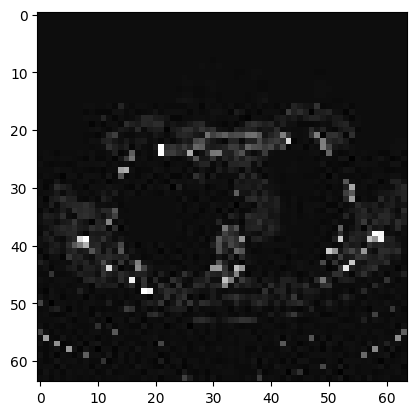

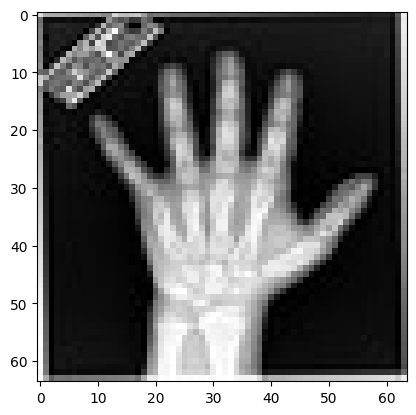

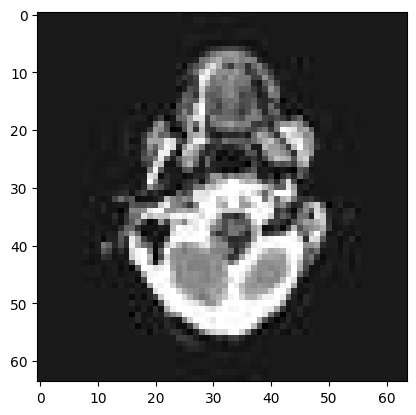

In [65]:
import random # putem folosi random.choice pentru a alege aleator dintr-o listă
for i in range(len(class_names)):
  img_path = random.choice(image_files[i])
  img = PIL.Image.open(img_path)
  #show the image
  plt.imshow(img, cmap='gray')
  plt.show()
# TODO 2

### Exercițiul 3

Există foarte multe arhitecturi neurale bazate pe straturi convoluționale care obțin rezultate spectaculoase pentru diverse sarcini de lucru ce presupun analizarea unor imagini: clasificarea imaginilor, segmentarea imaginilor, detecția obiectelor în imagini etc.

LeNet-5 reprezintă cea mai veche arhitectura convoluțională ce a fost propusă în anul 1998. Această arhitectură a fost proiectată de Yan LeCun *et al.* ( [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)) cu scopul de recunoaște cifre scrise de mână în documente scanate.

### Arhitectura modelului neural

Această arhitectură a fost concepută pentru imagini de rezoluție mică și conține o adâncime mică (doar două straturi convoluționale) din cauza constrângerilor care existau în vremea respectivă la nivel de putere de calcul.

![alt text](https://i.imgur.com/VDOzp4t.jpg)

### Implementarea modelului neural

În blocul de cod următor avem definită o clasă ce reprezintă implementarea modelului neural. În constructorul acestei clase avem definite straturile pe care le aplică această rețea. Pentru această cerința va trebui să completați implementarea funcției **forward**.

In [56]:
class LeNet(nn.Module):
    def __init__(self, in_size, out_size):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_size, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_size)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()

    def forward(self, x):
        # TODO 3
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.pool(x)
        x = self.relu(x)


        x = x.view(-1, 5*5*16)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        return x

    def name(self):
        return "LeNet"

### Exercițiul 4

Framework-ul pytorch permite rularea modelului neural pe GPU. Pentru acest lucru, putem folosi instrucțiunea:

```
model = model.cuda()
```

Instanțiați rețeaua neurală LeNet folosind 1 pentru ```in_size``` și ```num_class``` pentru ```out_size```. Dacă avem disponibilă vreo placă video, ne asigurăm că permitem rularea modelului pe GPU. De asemenea variabila ```device``` va primi valoarea ```"cuda"``` în acest caz.

In [57]:
use_cuda = torch.cuda.is_available()
device = "cuda"
# TODO 4
model = LeNet(in_size=1, out_size=num_class).to(device)

Pentru a putea estima valorile ponderilor modelului neural, avem nevoie de două concepte importante:


1.   Algoritmul de optimizare $-$ Pentru procesul de optimizare vom folosi algoritmul Stochastic Gradient Descent (Hint: ```optim.SGD```).
2.   Funcția de eroare $-$ Am văzut în cadrul cursului că pentru o problemă de clasificare multi-clasă putem utiliza funcția de eroarea Cross-Entropy împreună cu funcția de activare Softmax. În pytorch avem clasa ```torch.nn.CrossEntropyLoss```, iar în cadrul implementării se aplică înainte funcția de activare Softmax. Astfel, nu este nevoie să transformăm într-o distribuție de probabilitate predicția rețelei.



In [58]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
loss_function = torch.nn.CrossEntropyLoss()

### Exercițiul 5

Pornind de la lista ```image_files_list``` (care conține căile fișierelor de imagini) și ```image_class``` (etichetele aferente), împărțiți setul de date în trei subseturi: antrenare, validare și test, folosind câte 5% pentru validare și test. Afișați numărul de imagini din fiecare subset.


In [59]:
val_frac = 0.05
test_frac = 0.05
train_frac = 0.5
length = len(image_files_list)
train_length = int(train_frac * length)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:train_length]

# TODO 7
train_x = [image_files_list[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

train_y = [image_class[i] for i in train_indices]
val_y = [image_class[i] for i in val_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_y)}, Validation count: " f"{len(val_y)}, Test count: {len(test_y)}")

Training count: 23583, Validation count: 2947, Test count: 2947
Training count: 23583, Validation count: 2947, Test count: 2947


### Exercițiul 6

În continuare vom defini o serie de transformări care vor fi folosite pentru prelucrarea imaginilor și pentru procesarea predicțiilor.

In [60]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        Resize(spatial_size=(32, 32))
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity(),  Resize(spatial_size=(32, 32))])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

În continuare este furnizată o clasă personalizată ```MedNISTDataset``` care va servi drept dataset pentru imagini în format MedNIST.

Implementați metoda ```__len__()``` astfel încât să returneze numărul total de imagini din dataset. Aceasta ar trebui să fie echivalentă cu lungimea listei ```image_files```.

Implementați metoda ```__getitem__(index)```, care trebuie să returneze imaginea și eticheta de la poziția specificată de ```index```. În această metodă:

    
*   Aplicați secvența de transformări (self.transforms) asupra imaginii pentru a o pregăti pentru modelul de învățare automată.
*   Returnați imaginea transformată împreună cu eticheta corespunzătoare (sub formă de tuplu).

    

In [61]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
       # TODO 8
       return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]
      # TODO 9


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Exercițiul 7

Analizați codul urmărind fiecare etapă și încercați să înțelegeți structura și scopul secțiunilor esențiale:


*   Definirea parametrilor de antrenare și metrica ```ROCAUCMetric```.
*   Bucla de antrenare care trece prin fiecare batch, determină o predicție, calculează gradienții, aplică pasul de optimizare.
* Bucla de validare care calculează AUC și acuratețea, salvând cel mai bun model.

După ce ați analizat codul, rulați procesul de antrenare. Observați mesajele afișate, inclusiv valorile funcției de eroare pe batch-uri, respectiv valorile AUC și acuratețea pentru fiecare epocă.



In [62]:
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4
1/78, train_loss: 1.7994
2/78, train_loss: 1.8006
3/78, train_loss: 1.7922
4/78, train_loss: 1.7883
5/78, train_loss: 1.7847
6/78, train_loss: 1.8014
7/78, train_loss: 1.7948
8/78, train_loss: 1.7962
9/78, train_loss: 1.7907
10/78, train_loss: 1.7898
11/78, train_loss: 1.7909
12/78, train_loss: 1.7975
13/78, train_loss: 1.7903
14/78, train_loss: 1.7933
15/78, train_loss: 1.7876
16/78, train_loss: 1.7918
17/78, train_loss: 1.7900
18/78, train_loss: 1.7862
19/78, train_loss: 1.7836
20/78, train_loss: 1.7874
21/78, train_loss: 1.7843
22/78, train_loss: 1.7918
23/78, train_loss: 1.7788
24/78, train_loss: 1.7795
25/78, train_loss: 1.7808
26/78, train_loss: 1.7803
27/78, train_loss: 1.7812
28/78, train_loss: 1.7744
29/78, train_loss: 1.7763
30/78, train_loss: 1.7763
31/78, train_loss: 1.7744
32/78, train_loss: 1.7730
33/78, train_loss: 1.7696
34/78, train_loss: 1.7689
35/78, train_loss: 1.7725
36/78, train_loss: 1.7743
37/78, train_loss: 1.7635
38/78, train_loss: 1.7649


### Afișarea graficelor

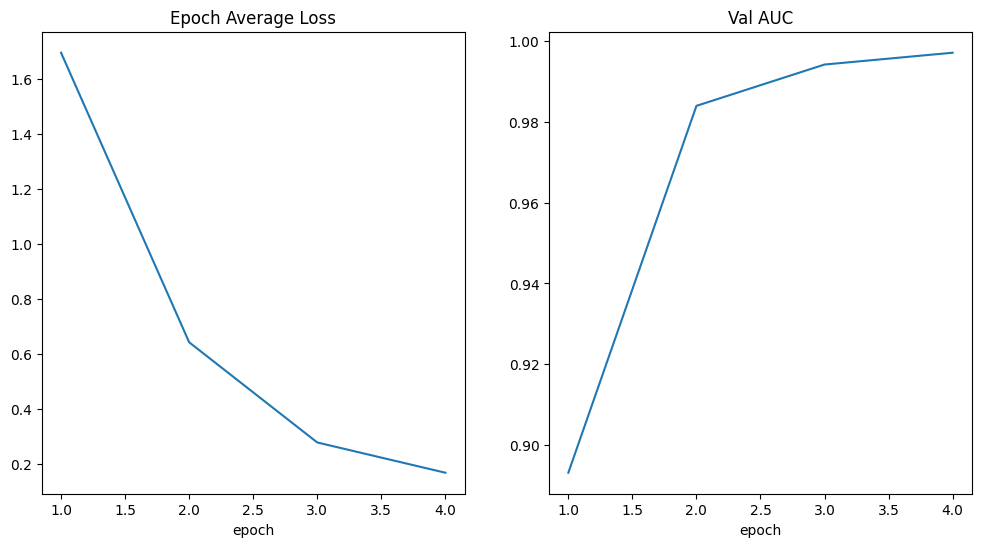

In [63]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluarea modelului

In [64]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

<ipython-input-64-030c29d441cd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


              precision    recall  f1-score   support

   AbdomenCT     0.9751    0.9550    0.9649       533
   BreastMRI     0.9836    0.9654    0.9744       434
         CXR     0.9896    0.9855    0.9876       484
     ChestCT     0.9009    0.9877    0.9423       488
        Hand     0.9861    0.9668    0.9763       512
      HeadCT     0.9792    0.9476    0.9631       496

    accuracy                         0.9678      2947
   macro avg     0.9691    0.9680    0.9681      2947
weighted avg     0.9690    0.9678    0.9680      2947

